# Assignment 4
## Exercise 1
serial version of the wildfire simulation:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import timeit

In [2]:
# Constants
GRID_SIZE = 800  # 800x800 forest grid
FIRE_SPREAD_PROB = 0.3  # Probability that fire spreads to a neighboring tree
BURN_TIME = 3  # Time before a tree turns into ash
DAYS = 60  # Maximum simulation time

# State definitions
EMPTY = 0  # No tree
TREE = 1  # Healthy tree
BURNING = 2  # Burning tree
ASH = 3  # Burned tree
NUM_WORKERS = 8  # Number of workers to use for parallel processing

In [3]:
def initialize_forest():
    """Creates a forest grid with all trees and ignites one random tree."""
    forest = np.ones((GRID_SIZE, GRID_SIZE), dtype=int)  # All trees
    burn_time = np.zeros(
        (GRID_SIZE, GRID_SIZE), dtype=int
    )  # Tracks how long a tree burns

    # Ignite a random tree
    x, y = random.randint(0, GRID_SIZE - 1), random.randint(0, GRID_SIZE - 1)
    forest[x, y] = BURNING
    burn_time[x, y] = 1  # Fire starts burning

    return forest, burn_time

In [4]:
def get_neighbors(x, y):
    """Returns the neighboring coordinates of a cell in the grid."""
    neighbors = []
    for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:  # Up, Down, Left, Right
        nx, ny = x + dx, y + dy
        if 0 <= nx < GRID_SIZE and 0 <= ny < GRID_SIZE:
            neighbors.append((nx, ny))
    return neighbors

In [5]:
def simulate_wildfire():
    """Simulates wildfire spread over time."""
    forest, burn_time = initialize_forest()
    
    fire_spread = []  # Track number of burning trees each day
    
    for day in range(DAYS):
        new_forest = forest.copy()
        
        for x in range(GRID_SIZE):
            for y in range(GRID_SIZE):
                if forest[x, y] == BURNING:
                    burn_time[x, y] += 1  # Increase burn time
                    
                    # If burn time exceeds threshold, turn to ash
                    if burn_time[x, y] >= BURN_TIME:
                        new_forest[x, y] = ASH
                    
                    # Spread fire to neighbors
                    for nx, ny in get_neighbors(x, y):
                        if forest[nx, ny] == TREE and random.random() < FIRE_SPREAD_PROB:
                            new_forest[nx, ny] = BURNING
                            burn_time[nx, ny] = 1
        
        forest = new_forest.copy()
        fire_spread.append(np.sum(forest == BURNING))
        
        if np.sum(forest == BURNING) == 0:  # Stop if no more fire
            break
        
        # # Plot grid every 5 days
        # if day % 5 == 0 or day == DAYS - 1:
        #     plt.figure(figsize=(6, 6))
        #     plt.imshow(forest, cmap='viridis', origin='upper')
        #     plt.title(f"Wildfire Spread - Day {day}")
        #     plt.colorbar(label="State: 0=Empty, 1=Tree, 2=Burning, 3=Ash")
        #     plt.show()
    
    return fire_spread

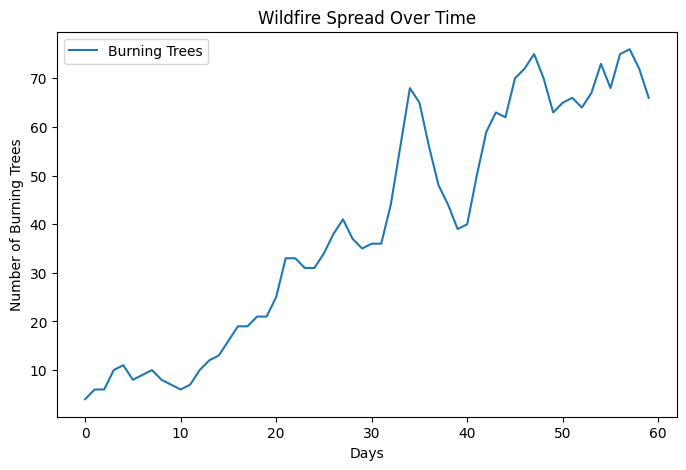

In [6]:
# Run simulation
start_time = timeit.default_timer()
fire_spread_over_time = simulate_wildfire()
for _ in range(NUM_WORKERS - 1):
    fire_spread_over_time = simulate_wildfire()
end_time = timeit.default_timer()
serial_time = end_time - start_time

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(
    range(len(fire_spread_over_time)), fire_spread_over_time, label="Burning Trees"
)
plt.xlabel("Days")
plt.ylabel("Number of Burning Trees")
plt.title("Wildfire Spread Over Time")
plt.legend()
plt.show()

### Task 1.1 - Parallelization with Multiprocessing

In [7]:
import multiprocess as mp

In [8]:
def mp_simulate_wildfire(id):
    return simulate_wildfire()

In [9]:
# Run simulation
start_time = timeit.default_timer()
with mp.Pool(NUM_WORKERS) as pool:
    fire_spread_over_time = pool.map(mp_simulate_wildfire, range(NUM_WORKERS))
end_time = timeit.default_timer()
mp_parallel_time = end_time - start_time    

fire_spread_over_time_np = np.zeros((NUM_WORKERS, DAYS), dtype=int)

for i, spread in enumerate(fire_spread_over_time):
    fire_spread_over_time_np[i, : len(spread)] = (
        spread
    )
    
result = np.mean(fire_spread_over_time_np, axis=0)

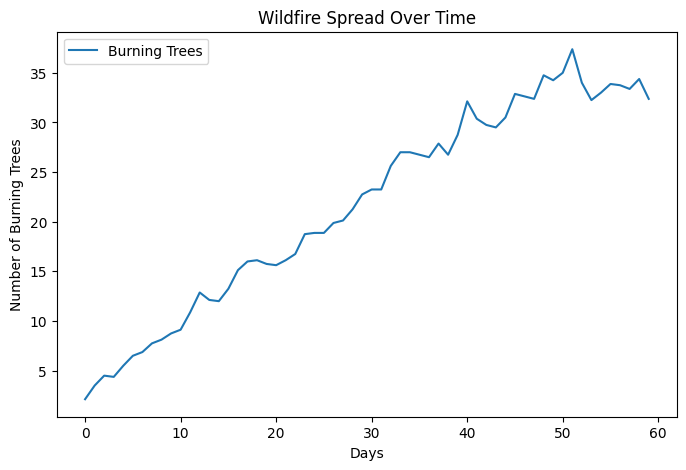

In [10]:
# Plot results
plt.figure(figsize=(8, 5))
plt.plot(
    range(len(result)), result, label="Burning Trees"
)
plt.xlabel("Days")
plt.ylabel("Number of Burning Trees")
plt.title("Wildfire Spread Over Time")
plt.legend()
plt.show()

### Task 1.2 - Parallelization with Dask

In [11]:
import dask
import dask.array as da
from dask.distributed import Client
client = Client()

In [12]:
@dask.delayed
def dask_simulate_wildfire():
    return simulate_wildfire()

In [13]:
# Run simulation
start_time = timeit.default_timer()
fire_spread_over_time = [dask_simulate_wildfire() for _ in range(NUM_WORKERS)]

computed_fire_spread = dask.compute(*fire_spread_over_time)
end_time = timeit.default_timer()
dask_parallel_time = end_time - start_time

fire_spread_over_time_np = da.from_array(np.zeros((NUM_WORKERS, DAYS), dtype=int), chunks=(NUM_WORKERS, DAYS))

for i, spread in enumerate(computed_fire_spread):
    fire_spread_over_time_np[i, : len(spread)] = (spread)

result = da.mean(fire_spread_over_time_np, axis=0).compute()

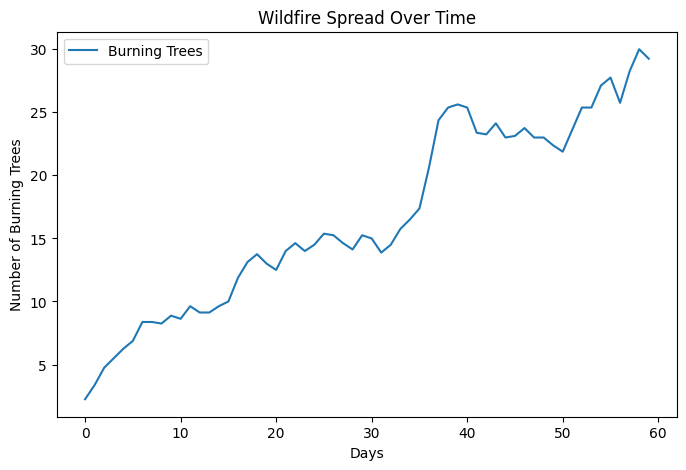

In [14]:
# Plot results
plt.figure(figsize=(8, 5))
plt.plot(range(len(result)), result, label="Burning Trees")
plt.xlabel("Days")
plt.ylabel("Number of Burning Trees")
plt.title("Wildfire Spread Over Time")
plt.legend()
plt.show()

### Task 1.3 - Performance Comparison

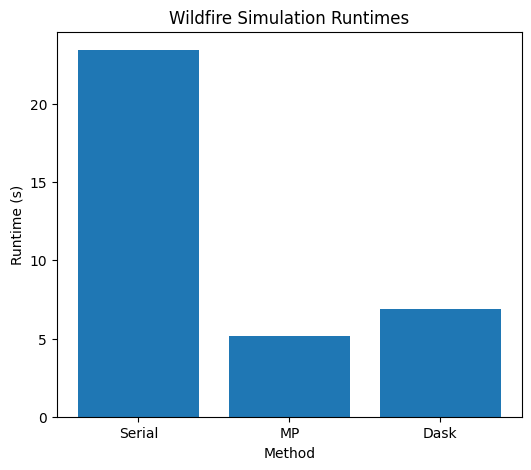

In [15]:
categories = ["Serial", "MP", "Dask"]
values = [serial_time, mp_parallel_time, dask_parallel_time]

# Create bar chart
plt.figure(figsize=(6, 5))
plt.bar(categories, values)

# Labels and title
plt.xlabel("Method")
plt.ylabel("Runtime (s)")
plt.title("Wildfire Simulation Runtimes")

# Show plot
plt.show()


### Task 1.4 - Visualization with Paraview and VTK

In [33]:
import pyvtk
np.float_ = np.float64

In [34]:
DAYS = 365

In [ ]:
def save_forest_to_vtk(filename, forest):
    nx, ny = forest.shape

    state_flat = forest.T.flatten()

    vtk_data = pyvtk.VtkData(
        pyvtk.StructuredPoints([nx, ny, 1]),  
        pyvtk.PointData(
            pyvtk.Scalars(state_flat, name="state") 
        ),
    )

    vtk_data.tofile(filename)


In [36]:
def vtk_simulate_wildfire():
    """Simulates wildfire spread over time."""
    forest, burn_time = initialize_forest()

    fire_spread = []  # Track number of burning trees each day

    for day in range(DAYS):
        new_forest = forest.copy()

        for x in range(GRID_SIZE):
            for y in range(GRID_SIZE):
                if forest[x, y] == BURNING:
                    burn_time[x, y] += 1  # Increase burn time

                    # If burn time exceeds threshold, turn to ash
                    if burn_time[x, y] >= BURN_TIME:
                        new_forest[x, y] = ASH

                    # Spread fire to neighbors
                    for nx, ny in get_neighbors(x, y):
                        if (
                            forest[nx, ny] == TREE
                            and random.random() < FIRE_SPREAD_PROB
                        ):
                            new_forest[nx, ny] = BURNING
                            burn_time[nx, ny] = 1

        forest = new_forest.copy()
        fire_spread.append(np.sum(forest == BURNING))

        # Write VTK file for visualization in ParaView
        vtk_filename = f"wildfire_day{day:03d}"
        save_forest_to_vtk(vtk_filename, forest)

        if np.sum(forest == BURNING) == 0:  # Stop if no more fire
            break

        # # Plot grid every 5 days
        # if day % 5 == 0 or day == DAYS - 1:
        #     plt.figure(figsize=(6, 6))
        #     plt.imshow(forest, cmap='viridis', origin='upper')
        #     plt.title(f"Wildfire Spread - Day {day}")
        #     plt.colorbar(label="State: 0=Empty, 1=Tree, 2=Burning, 3=Ash")
        #     plt.show()

    return fire_spread


In [37]:
# Run simulation and generate VTK files
vtk_simulate_wildfire()

[np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(3),
 np.int64(2),
 np.int64(2),
 np.int64(4),
 np.int64(4),
 np.int64(5),
 np.int64(5),
 np.int64(5),
 np.int64(7),
 np.int64(8),
 np.int64(7),
 np.int64(9),
 np.int64(13),
 np.int64(15),
 np.int64(20),
 np.int64(20),
 np.int64(17),
 np.int64(20),
 np.int64(20),
 np.int64(21),
 np.int64(25),
 np.int64(24),
 np.int64(26),
 np.int64(34),
 np.int64(43),
 np.int64(38),
 np.int64(34),
 np.int64(35),
 np.int64(30),
 np.int64(35),
 np.int64(42),
 np.int64(47),
 np.int64(44),
 np.int64(41),
 np.int64(48),
 np.int64(53),
 np.int64(56),
 np.int64(60),
 np.int64(56),
 np.int64(51),
 np.int64(53),
 np.int64(50),
 np.int64(42),
 np.int64(40),
 np.int64(46),
 np.int64(46),
 np.int64(48),
 np.int64(45),
 np.int64(40),
 np.int64(46),
 np.int64(52),
 np.int64(54),
 np.int64(53),
 np.int64(46),
 np.int64(41),
 np.int64(37),
 np.int64(33),
 np.int64(36),
 np.int64(31),
 np.int64(29),
 np.int64(26),
 np.int64(17),
 np.int64(21),
 np.int64(22),
 np.int64(